In [1]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [2]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [3]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [4]:
# label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [5]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    # print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape, reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [6]:
params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]
evals_result = {}  # 储存评估指标(内置和自定义)结果

model = lgb.train(params=params,
                  train_set=train_dataset,
                  early_stopping_rounds=20,  # 默认early_stopping_rounds=None
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  # This dictionary used to store all evaluation results of all the items in valid_sets.
                  evals_result=evals_result,
                  num_boost_round=200,  # 默认num_boost_round=1000
                  # Requires at least one validation data.
                  # If True, the eval metric on the valid set is printed at each boosting stage.
                  # If int, the eval metric on the valid set is printed at every verbose_eval boosting stage.
                  # The last boosting stage or the boosting stage found by using early_stopping_rounds is also printed.
                  verbose_eval=200,  # 默认verbose_eval=True
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	training's multi_logloss: 0.064242	training's MY_GBM_LOSS: 0.064242	valid_1's multi_logloss: 0.410924	valid_1's MY_GBM_LOSS: 0.410924


array([[2.32931799e-04, 2.97979026e-03, 1.18884866e-04, ...,
        9.96404474e-01, 1.41916035e-04, 6.37641400e-05],
       [4.07502277e-04, 7.91154166e-04, 9.83610854e-01, ...,
        5.20915817e-04, 1.40428645e-02, 1.07589003e-04],
       [2.17099150e-02, 9.69908363e-01, 1.15244663e-03, ...,
        4.66404801e-03, 1.37534669e-03, 6.21404748e-04],
       ...,
       [1.48607003e-04, 2.09106326e-03, 7.48324607e-05, ...,
        9.97519372e-01, 8.93295040e-05, 4.01365429e-05],
       [7.12499323e-02, 9.23635002e-01, 9.04386248e-04, ...,
        2.19918676e-03, 1.07870877e-03, 4.86843772e-04],
       [5.57330590e-01, 4.38178648e-01, 7.72008030e-04, ...,
        2.00028889e-03, 9.21030277e-04, 4.16970525e-04]])

In [7]:
# The best score of fitted model.
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 0.06424198382119609),
                          ('MY_GBM_LOSS', 0.06424198382119607)]),
             'valid_1': OrderedDict([('multi_logloss', 0.4109240544733994),
                          ('MY_GBM_LOSS', 0.4109240544733994)])})

In [8]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.3558848496663776,
                1.1582162580773407,
                1.0134594659917706,
                0.8973224675045901,
                0.8017355664086763,
                0.721995789067193,
                0.6530875050488275,
                0.593478203117382,
                0.5419823243909939,
                0.4972489324632931,
                0.4570053434863537,
                0.42056181849652535,
                0.3885501826792482,
                0.3607817522142825,
                0.33407752961605447,
                0.31035008158118244,
                0.28869970945724543,
                0.26844076442783,
                0.25094115030780306,
                0.23459792850292602,
                0.21985211989548745,
                0.20600127495862136,
                0.19409540871667813,
                0.1827531156042424,
                0.17156496557524176,
                0.16164409741786281,
             

In [9]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

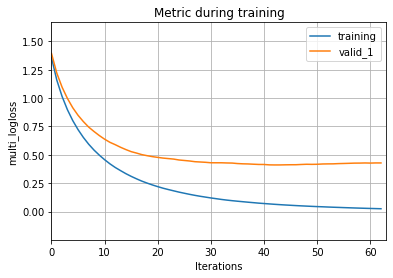

In [10]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

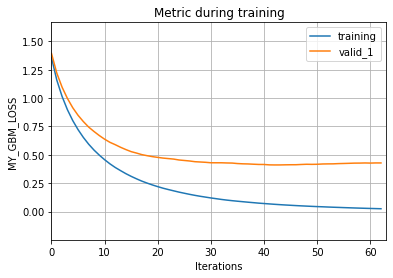

In [11]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [12]:
# 特征的相对重要性
model.feature_importance()

array([1552,  575,  364,  780,  594, 1367,  589,  570,  616, 1200,  120,
          0,   27,   29,   42,   12,    0,    0,    7,    0,    0,    0,
          0,   32,    0,   90,   27,    0,    0,    0,   14,    1,    0,
        103,    0,    3,   36,    7,    0,    0,    0,    0,   63,   89,
          2,    0,   27,    0,    0,    0,    0,   18,   11,    0])

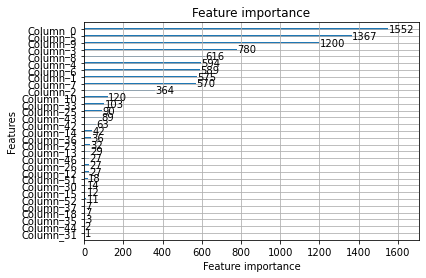

In [13]:
# 绘制特征的相对重要性
lgb.plot_importance(model)
plt.show()

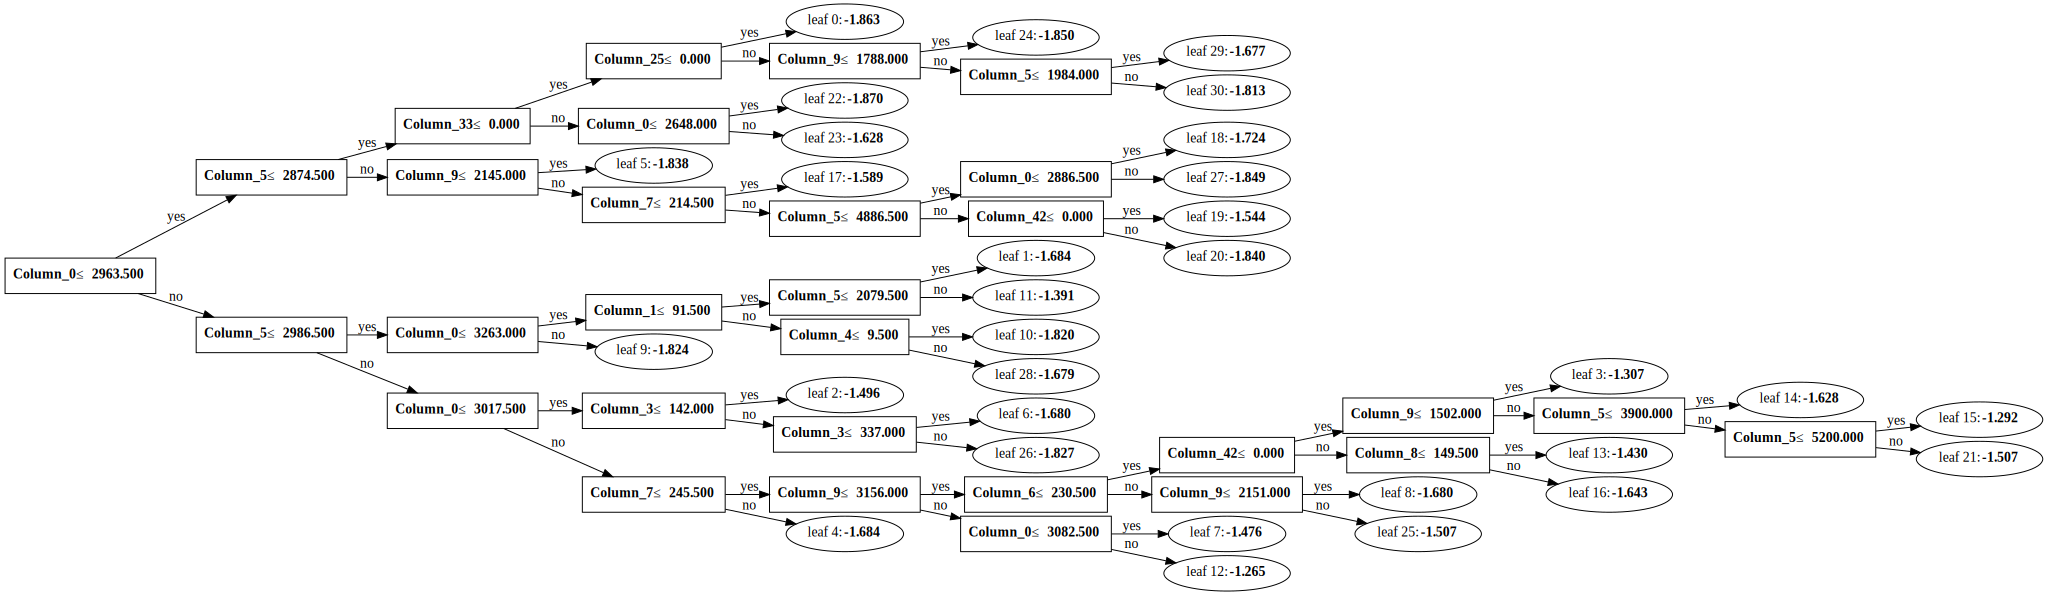

In [14]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [15]:
# 数据类型为graphviz.dot.Digraph
type(img)

graphviz.dot.Digraph

In [16]:
# 图保存
img.view(filename="img_view.gv")


'img_view.gv.pdf'